<a href="https://colab.research.google.com/github/HippocampusTeam/DNNT-TensorFlow/blob/graph/DNNT_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
import csv
import time
import datetime

import tensorflow as tf
import tensorflow.compat.v1 as tf1
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split

TensorFlow functions

In [ ]:
@tf.function
def train_step(x, y, model, optimizer, loss_fn, train_acc_metric):
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = loss_fn(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss(loss)
    train_accuracy(y_train, predictions)

    return loss


@tf.function
def test_step(x, y, model, val_acc_metric):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)
    loss = loss_fn(y, val_logits)

    test_loss(loss)
    test_accuracy(y, val_logits)

Test

In [ ]:
# Read data in from file
with open("/content/drive/MyDrive/DNNT/data/banknotes.csv") as f:
    reader = csv.reader(f)
    next(reader)

    data = []
    for row in reader:
        data.append({
            "evidence": [float(cell) for cell in row[:4]],
            "label": 1 if row[4] == "0" else 0
        })

# Separate data into training and testing groups
evidence = [row["evidence"] for row in data]
labels = [row["label"] for row in data]
X_training, X_testing, y_training, y_testing = train_test_split(
    evidence, labels, test_size=0.4
)

In [ ]:
# Create a neural network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(3, input_shape=(4,), activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# Train neural network
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(X_training, y_training, epochs=15)
#
# # Evaluate how well model performs
# model.evaluate(X_testing, y_testing, verbose=2)

Epoch 1/15
26/26 [==============================] - 0s 983us/step - loss: 0.4458 - accuracy: 0.8463
Epoch 2/15
26/26 [==============================] - 0s 1ms/step - loss: 0.4027 - accuracy: 0.9063
Epoch 3/15
26/26 [==============================] - 0s 1ms/step - loss: 0.3575 - accuracy: 0.9250
Epoch 4/15
26/26 [==============================] - 0s 1ms/step - loss: 0.3452 - accuracy: 0.9259
Epoch 5/15
26/26 [==============================] - 0s 1ms/step - loss: 0.3298 - accuracy: 0.8986
Epoch 6/15
26/26 [==============================] - 0s 1ms/step - loss: 0.3056 - accuracy: 0.9393
Epoch 7/15
26/26 [==============================] - 0s 1ms/step - loss: 0.3016 - accuracy: 0.9223
Epoch 8/15
26/26 [==============================] - 0s 1ms/step - loss: 0.2894 - accuracy: 0.9212
Epoch 9/15
26/26 [==============================] - 0s 1ms/step - loss: 0.2462 - accuracy: 0.9369
Epoch 10/15
26/26 [==============================] - 0s 1ms/step - loss: 0.2566 - accuracy: 0.9418
Epoch 11/15
26/26

In [ ]:
def graph2D(model, index, x_train, y_train, n):
    weights = model.get_weights()
    if len(index) == 3:
        weights[index[0]][index[1]][index[2]] = n
    else:
        weights[index[0]][index[1]] = n
    model.set_weights(weights)
    predictions = model.predict(x_train)
    loss = tf.keras.losses.binary_crossentropy(y_train, predictions)
    if len(index) == 3:
        return (model.get_weights()[index[0]][index[1]][index[2]], np.mean(loss))
    else:
        return (model.get_weights()[index[0]][index[1]], np.mean(loss))

In [ ]:
x = list()
y = list()
def add_weight(index):
    x.append(list())
    y.append(list())
    model_copy = tf.keras.models.clone_model(model)
    for i in np.linspace(-2, 2, 50):
        cur = graph2D(model_copy, index, X_testing, y_testing, i)
        x[-1].append(cur[0])
        y[-1].append(cur[1])

In [ ]:
def add_all():
    w = model.get_weights()
    for i in range(len(w)):
        for j in range(len(w[i])):
            if isinstance(w[i][j], np.ndarray):
                for k in range(len(w[i][j])):
                    add_weight((i, j, k))
            else:
                add_weight((i, j))
add_all()

In [ ]:
print(model.get_weights())

[array([[-0.7059722 , -0.93293357,  0.27436855, -1.0327246 ],
       [ 0.5638637 ,  0.6982932 ,  0.52283686, -0.33282334],
       [ 0.18857582, -0.5283083 ,  0.13139778, -0.25498453],
       [ 0.14558339,  0.39641026,  0.41626185, -0.1980442 ]],
      dtype=float32), array([-0.12324585,  0.2851991 , -0.01535906,  0.30080074], dtype=float32), array([[ 0.06684455],
       [-0.23977357],
       [ 1.0856732 ],
       [-1.065724  ]], dtype=float32), array([0.15303977], dtype=float32)]


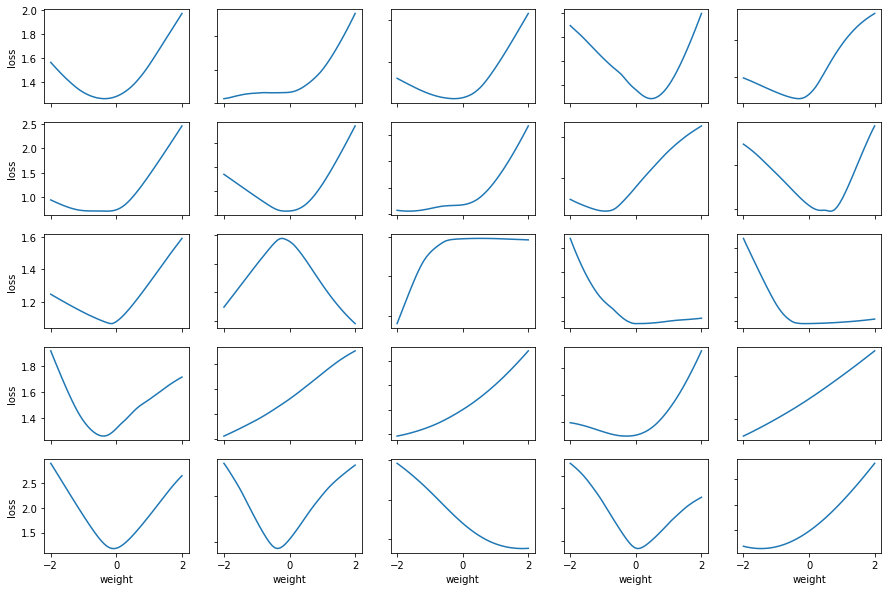

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(15, 10))
for i in range(25):
    axs[i // 5, i % 5].plot(x[i], y[i])

for ax in axs.flat:
    ax.set(xlabel='weight', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

In [ ]:
def graph3D(model, index, x_train, y_train, n):
    weights = model.get_weights()
    if len(index) == 3:
        weights[index[0]][index[1]][index[2]] = n
    else:
        weights[index[0]][index[1]] = n
    model.set_weights(weights)
    predictions = model.predict(x_train)
    loss = tf.keras.losses.binary_crossentropy(y_train, predictions)
    if len(index) == 3:
        return (model.get_weights()[index[0]][index[1]][index[2]], np.mean(loss))
    else:
        return (model.get_weights()[index[0]][index[1]], np.mean(loss))